# NLP Text Analysis: Pride and Prejudice by Jane Austen


1. **Data Preparation** -- Tokenization, lowercasing, punctuation removal, stop-word removal, and stemming.
2. **Word Statistics** -- Frequency distribution, occurrence counts, and word cloud generation.
3. **Document-Based Analysis** -- Chapter-level segmentation, per-document preprocessing, and TF-IDF computation.
4. **Visualization** -- Per-document and combined word clouds weighted by TF-IDF scores.

In [13]:
import subprocess
import sys
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

required_packages = ["nltk", "wordcloud", "matplotlib", "scikit-learn", "numpy"]

# Map pip names -> import names
import_name_map = {
    "scikit-learn": "sklearn"
}

for pkg in required_packages:
    import_name = import_name_map.get(pkg, pkg.replace("-", "_"))
    try:
        __import__(import_name)
    except ImportError:
        logger.info("Installing missing package: %s", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--disable-pip-version-check", pkg])

logger.info("All required packages are available.")

In [14]:
from google.colab import files
uploaded = files.upload()

Saving Pride and Perjudice.txt to Pride and Perjudice (1).txt


In [15]:
import os
import re
import math
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)

ALPHA_PATTERN = re.compile(r"^[a-z]+$")
MIN_WORD_LENGTH = 3

logger.info("Imports and NLTK resources loaded successfully.")

---
## 1. Data Preparation

### (a) Load text file and tokenize into individual words

In [16]:
# ================================
# Load Pride and Prejudice file
# ================================

file_path = "/content/Pride and Perjudice.txt"

# Check file exists
if not os.path.exists(file_path):
    print("Available files in /content:", os.listdir("/content"))
    raise FileNotFoundError(
        f"Text file not found at: {file_path}\n"
        f"Please upload the file again in Colab."
    )

# Read file
with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
    raw_text = f.read()

# ============================================
# Locate actual novel start and end
# ============================================

start_marker = "It is a truth universally acknowledged"
start_idx = raw_text.find(start_marker)

if start_idx == -1:
    raise ValueError("Could not locate the beginning of the novel.")

end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"
end_idx = raw_text.find(end_marker)
if end_idx == -1:
    end_idx = len(raw_text)

book_text = raw_text[start_idx:end_idx].strip()

# ============================================
# Clean Gutenberg artefacts
# ============================================

book_text = re.sub(r"\[Illustration[^\]]*\]", " ", book_text, flags=re.DOTALL)
book_text = re.sub(r"_Copyright \d{4} by [^_]+_", " ", book_text)
book_text = re.sub(r"\s{3,}", " ", book_text)

print(f" Novel text extracted: {len(book_text)} characters after cleaning.")

# ======================================================
# Select passage = Chapter I to Chapter IV only
# ======================================================

# In this edition Chapter I heading was removed with illustration,
# so book_text already starts from Chapter I content.
# We find Chapter V and cut before it.

chapter_pattern = re.compile(r"\bChapter\s+([IVXLC]+)\.", re.IGNORECASE)
matches = list(chapter_pattern.finditer(book_text))

if len(matches) < 4:
    raise ValueError("Could not find enough chapter headings.")

# Chapter V is usually the 4th match (since Chapter I heading was removed)
# So we cut at the start of Chapter V
end_index = matches[3].start()

passage_text = book_text[:end_index].strip()

# Save passage to text file (required for submission)
passage_file = "pride_prejudice_ch1_to_ch4.txt"
with open(passage_file, "w", encoding="utf-8") as f:
    f.write(passage_text)

print(f" Passage (Chapter I–IV) saved: {passage_file}")
print(f" Passage length: {len(passage_text)} characters")

# Quick boundary check
print("\n--- Passage START ---\n", passage_text[:300])
print("\n--- Passage END ---\n", passage_text[-300:])

# Optional sanity token check
raw_tokens = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", passage_text)
print(f"\n Total raw tokens in passage: {len(raw_tokens)}")
print(" First 30 tokens:", raw_tokens[:30])

 Novel text extracted: 685937 characters after cleaning.
 Passage (Chapter I–IV) saved: pride_prejudice_ch1_to_ch4.txt
 Passage length: 24344 characters

--- Passage START ---
 It is a truth universally acknowledged, that a single man in possession
of a good fortune must be in want of a wife.

However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he i

--- Passage END ---
 ster allowed it to be so; but still they admired
her and liked her, and pronounced her to be a sweet girl, and one whom
they should not object to know more of. Miss Bennet was therefore
established as a sweet girl; and their brother felt authorized by such
commendation to think of her as he chose. ]

 Total raw tokens in passage: 4441
 First 30 tokens: ['It', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must',

### (b) Preprocess: lowercase, remove punctuation, remove stop-words

In [17]:
english_stopwords = set(stopwords.words("english"))

lowered_tokens = [token.lower() for token in raw_tokens]
logger.info("Tokens after lowercasing: %d", len(lowered_tokens))

# strict punctuation removal: token must be ONLY letters
alpha_tokens = [token for token in lowered_tokens if ALPHA_PATTERN.match(token)]
logger.info("Tokens after punctuation removal: %d", len(alpha_tokens))

filtered_tokens = [token for token in alpha_tokens if token not in english_stopwords]
logger.info("Tokens after stop-word removal: %d", len(filtered_tokens))

CUSTOM_BLOCKLIST = {"chapter", "mr", "mrs", "miss"}  # add more if you want
filtered_tokens = [t for t in filtered_tokens if t not in CUSTOM_BLOCKLIST]

filtered_tokens = [token for token in filtered_tokens if len(token) >= MIN_WORD_LENGTH]
logger.info("Tokens after short-word removal (len < %d): %d", MIN_WORD_LENGTH, len(filtered_tokens))
logger.info("Sample filtered tokens: %s", filtered_tokens[:25])

### (c) Apply stemming algorithm



In [18]:
stemmer = SnowballStemmer("english")

stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

# Optional safety filter
BAD_STEMS = {"chapter"}
stemmed_tokens = [t for t in stemmed_tokens if t not in BAD_STEMS]

logger.info("Tokens after stemming: %d", len(stemmed_tokens))

comparison_sample = list(zip(filtered_tokens[:15], stemmed_tokens[:15]))
logger.info("Original vs Stemmed (first 15):")
for original, stemmed in comparison_sample:
    print(f"  {original:20s} -> {stemmed}")

  truth                -> truth
  universally          -> univers
  acknowledged         -> acknowledg
  single               -> singl
  man                  -> man
  possession           -> possess
  good                 -> good
  fortune              -> fortun
  must                 -> must
  want                 -> want
  wife                 -> wife
  however              -> howev
  little               -> littl
  known                -> known
  feelings             -> feel


---
## 2. Word Statistics

### (d) Compute frequency distribution of all processed words

Rank  Word                Frequency 
------------------------------------
1     bingley             38        
2     bennet              31        
3     danc                19        
4     one                 18        
5     much                18        
6     said                17        
7     good                15        
8     dear                15        
9     know                15        
10    man                 14        
11    ladi                14        
12    girl                14        
13    darci               14        
14    sister              13        
15    like                12        
16    visit               12        
17    never               12        
18    room                12        
19    see                 11        
20    handsom             11        
21    would               11        
22    could               11        
23    must                10        
24    daughter            10        
25    though              10        
2

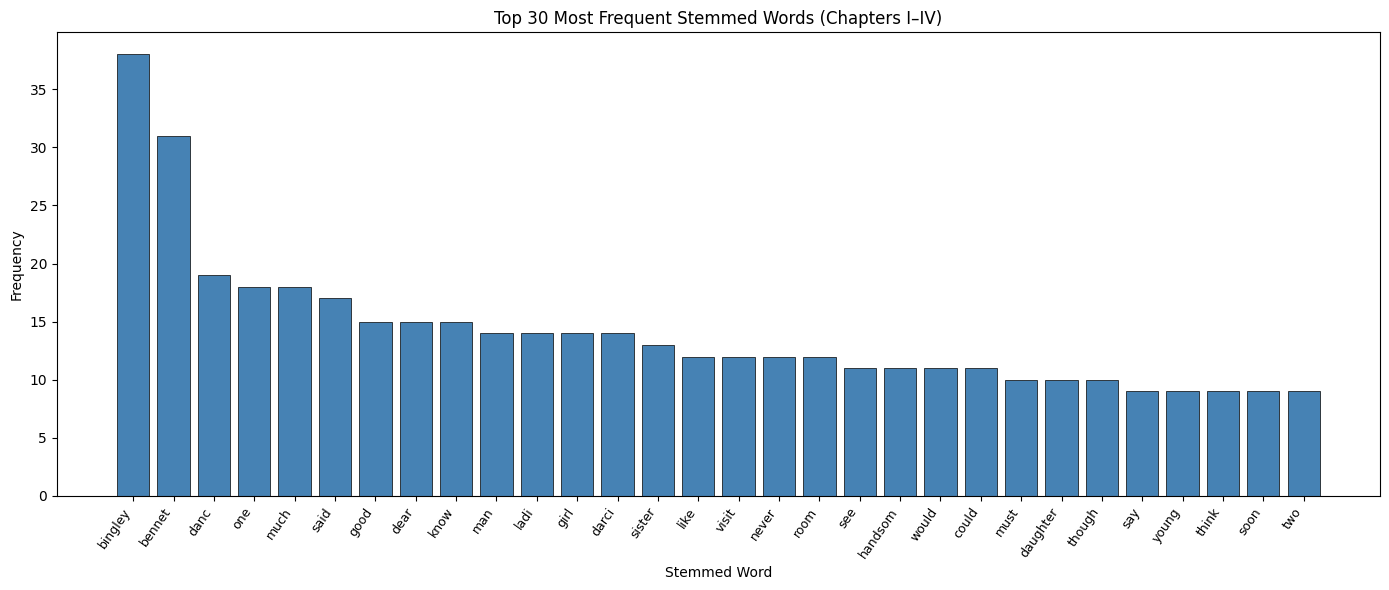

In [19]:
freq_dist = Counter(stemmed_tokens)

logger.info("Unique stemmed words: %d", len(freq_dist))

top_30 = freq_dist.most_common(30)

logger.info("Top 30 most frequent stemmed words:")
print(f"{'Rank':<6}{'Word':<20}{'Frequency':<10}")
print("-" * 36)

for rank, (word, count) in enumerate(top_30, 1):
    print(f"{rank:<6}{word:<20}{count:<10}")

words_top30, counts_top30 = zip(*top_30)

plt.figure(figsize=(14, 6))
plt.bar(words_top30, counts_top30,
        color="steelblue",
        edgecolor="black",
        linewidth=0.5)

plt.xlabel("Stemmed Word")
plt.ylabel("Frequency")
plt.title("Top 30 Most Frequent Stemmed Words (Chapters I–IV)")
plt.xticks(rotation=55, ha="right", fontsize=9)
plt.tight_layout()
plt.show()

### (e) Count total number of occurrences of each word

In [20]:
total_token_count = sum(freq_dist.values())
unique_token_count = len(freq_dist)

logger.info("Total word occurrences (after all preprocessing, Chapters I–IV): %d", total_token_count)
logger.info("Unique word types (Chapters I–IV): %d", unique_token_count)

bracket_labels = [
    "Appears once (hapax legomena)",
    "Appears 2-5 times",
    "Appears 6-20 times",
    "Appears 21-100 times",
    "Appears >100 times",
]
bracket_counts = [0, 0, 0, 0, 0]

for count in freq_dist.values():
    if count == 1:
        bracket_counts[0] += 1
    elif count <= 5:
        bracket_counts[1] += 1
    elif count <= 20:
        bracket_counts[2] += 1
    elif count <= 100:
        bracket_counts[3] += 1
    else:
        bracket_counts[4] += 1

print(f"\n{'Frequency Bracket':<40}{'Word Count':<12}")
print("-" * 52)
for label, cnt in zip(bracket_labels, bracket_counts):
    print(f"{label:<40}{cnt:<12}")


Frequency Bracket                       Word Count  
----------------------------------------------------
Appears once (hapax legomena)           431         
Appears 2-5 times                       251         
Appears 6-20 times                      77          
Appears 21-100 times                    2           
Appears >100 times                      0           


### (f) generate word cloud



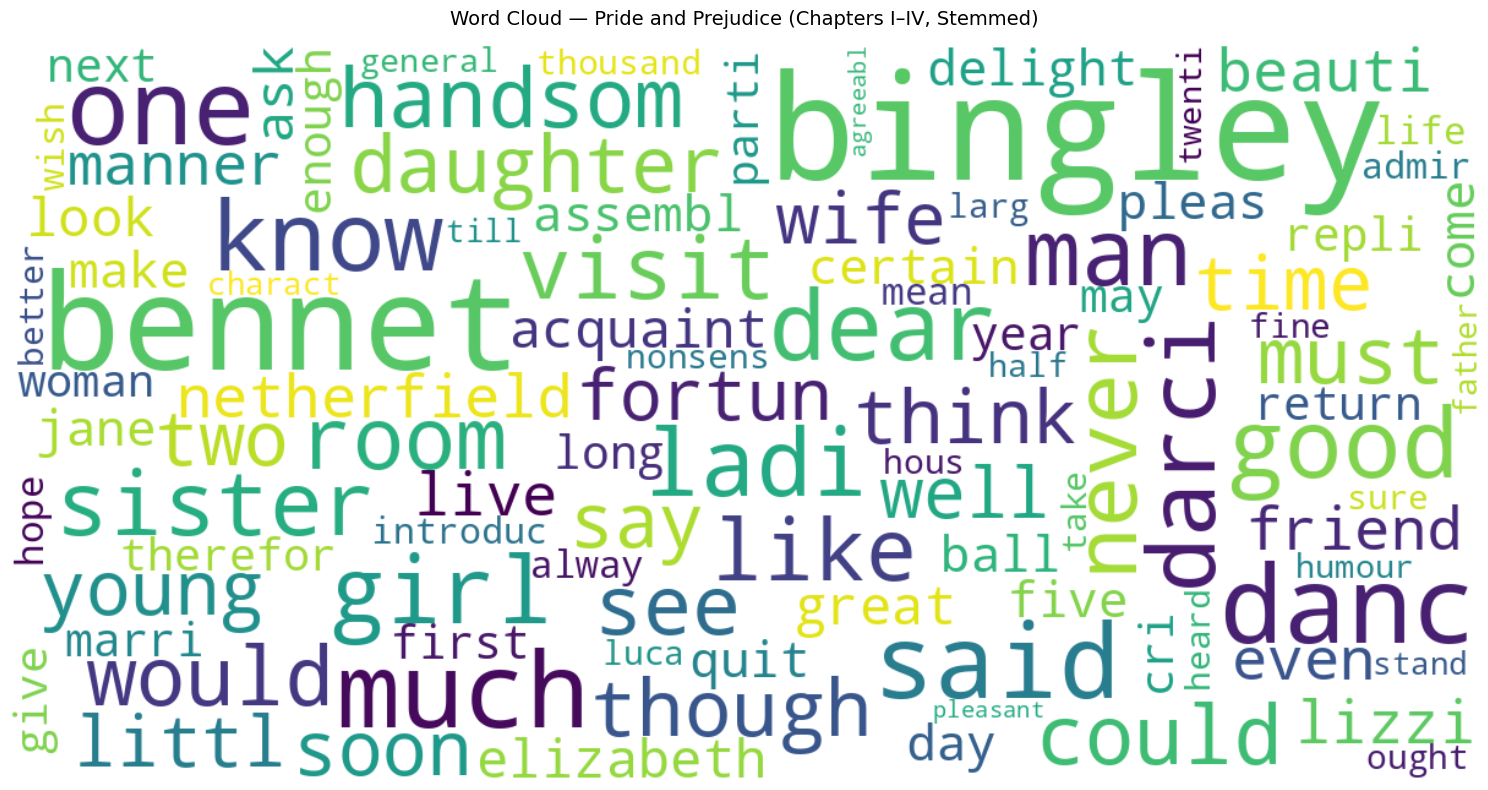

In [21]:
# Optional safety filter
clean_freq = {w: c for w, c in freq_dist.items() if w not in {"chapter"}}

wordcloud_basic = WordCloud(
    width=1200,
    height=600,
    max_words=100,
    background_color="white",
    colormap="viridis",
    collocations=False,
    min_font_size=8,
    max_font_size=120,
    random_state=42
).generate_from_frequencies(clean_freq)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_basic, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Pride and Prejudice (Chapters I–IV, Stemmed)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

# Save for submission
wordcloud_basic.to_file("wordcloud_ch1_to_ch4.png")

---
## 3. Analysis


In [22]:
chapter_pattern = re.compile(r"CHAPTER\s+[IVXLC]+\.?", re.IGNORECASE)

splits = list(chapter_pattern.finditer(book_text))
logger.info("CHAPTER headings found by regex: %d", len(splits))

chapters = []

# Chapter I has no standard heading in this edition (it was inside an [Illustration] tag that was stripped).
# The text before the first CHAPTER heading is Chapter I.
if splits:
    ch1_text = book_text[:splits[0].start()].strip()
    if len(ch1_text) > 100:
        chapters.append(ch1_text)
        logger.info("Chapter I extracted from text before first heading (%d chars).", len(ch1_text))

for i, match in enumerate(splits):
    start = match.start()
    end = splits[i + 1].start() if i + 1 < len(splits) else len(book_text)
    chapter_text = book_text[start:end].strip()
    chapters.append(chapter_text)

logger.info("Total chapters assembled: %d", len(chapters))
logger.info("Chapter lengths (chars): min=%d, max=%d, mean=%d",
            min(len(c) for c in chapters),
            max(len(c) for c in chapters),
            sum(len(c) for c in chapters) // len(chapters))

# Use ONLY Chapters I–IV as separate documents
if len(chapters) < 4:
    raise ValueError("Less than 4 chapters found. Cannot create 4 documents (Chapters I–IV).")

documents_raw = chapters[:4]

for idx, doc in enumerate(documents_raw, start=1):
    logger.info("Document %d = Chapter %d, length=%d chars", idx, idx, len(doc))

### (h) Preprocess: tokenize, lowercase, remove punctuation, remove stop-words, stem

In [23]:
def preprocess_document(text, stemmer_obj, stop_words, min_length=MIN_WORD_LENGTH):
    """
    Full preprocessing pipeline for a single document.
    Returns both the list of stemmed tokens and a space-joined string
    suitable for TfidfVectorizer input.
    """
    tokens = word_tokenize(text)
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if ALPHA_PATTERN.match(t)]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if len(t) >= min_length]
    tokens = [stemmer_obj.stem(t) for t in tokens]
    tokens = [t for t in tokens if len(t) >= min_length]
    return tokens, " ".join(tokens)


doc_tokens_list = []
doc_strings_list = []

for idx, doc_raw in enumerate(documents_raw):
    tokens, joined = preprocess_document(doc_raw, stemmer, english_stopwords)
    doc_tokens_list.append(tokens)
    doc_strings_list.append(joined)
    logger.info("Document %d: %d tokens after full preprocessing", idx + 1, len(tokens))

### (i) Calculate TF-IDF weights

In [24]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    tokenizer=str.split,      # use preprocessed tokens
    preprocessor=None,
    token_pattern=None,       # must be None when tokenizer is provided
    lowercase=False,          # already lowercased
    norm="l2",
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False
)

tfidf_matrix = vectorizer.fit_transform(doc_strings_list)
feature_names = vectorizer.get_feature_names_out()

logger.info("TF-IDF matrix shape: %s (documents x unique terms)", tfidf_matrix.shape)

for doc_idx in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(doc_idx).toarray().flatten()
    nonzero_count = np.count_nonzero(row)
    top_indices = row.argsort()[-10:][::-1]
    top_terms = [(feature_names[i], round(row[i], 4)) for i in top_indices if row[i] > 0]

    logger.info(
        "Document %d: %d non-zero terms. Top 10 TF-IDF terms (sklearn, L2-normalized):",
        doc_idx + 1,
        nonzero_count
    )

    for term, score in top_terms:
        print(f"    {term:<20s} {score:.4f}")

    must                 0.2333
    dear                 0.2180
    singl                0.2089
    visit                0.2000
    see                  0.1666
    bennet               0.1635
    four                 0.1566
    want                 0.1566
    one                  0.1362
    know                 0.1362
    bennet               0.2506
    said                 0.2506
    cough                0.2134
    kitti                0.2134
    acquaint             0.1703
    long                 0.1683
    bingley              0.1671
    know                 0.1392
    visit                0.1362
    make                 0.1362
    danc                 0.2771
    bingley              0.2265
    bennet               0.1841
    sister               0.1497
    darci                0.1497
    could                0.1497
    partner              0.1357
    parti                0.1357
    even                 0.1283
    quit                 0.1283
    bingley              0.2437
    darc

In [25]:
def compute_tf(token_list):
    """Compute normalized term frequency for a single document."""
    tf_counts = Counter(token_list)
    total = len(token_list)
    return {term: count / total for term, count in tf_counts.items()} if total > 0 else {}


def compute_idf(doc_token_lists):
    """
    Compute inverse document frequency across all documents.
    Uses the classic formula: IDF(t) = log(N / df(t)) + 1
    Note: This differs from sklearn's smoothed version.
    """
    n_docs = len(doc_token_lists)
    df = Counter()
    for tokens in doc_token_lists:
        unique_terms = set(tokens)
        for term in unique_terms:
            df[term] += 1
    return {term: math.log(n_docs / doc_freq) + 1 for term, doc_freq in df.items()} if n_docs > 0 else {}


def compute_tfidf_manual(doc_token_lists):
    """
    Compute TF-IDF from scratch using textbook formulas.
    Returns a list of dictionaries, one per document, mapping term -> tfidf score.
    Scores are NOT L2-normalized (unlike sklearn) so they can be used directly
    as frequency weights for word cloud generation.
    """
    idf_scores = compute_idf(doc_token_lists)
    tfidf_per_doc = []
    for tokens in doc_token_lists:
        tf_scores = compute_tf(tokens)
        doc_tfidf = {term: tf_val * idf_scores[term] for term, tf_val in tf_scores.items() if term in idf_scores}
        tfidf_per_doc.append(doc_tfidf)
    return tfidf_per_doc


manual_tfidf = compute_tfidf_manual(doc_tokens_list)

logger.info("Manual TF-IDF computation complete.")
for idx, doc_scores in enumerate(manual_tfidf):
    sorted_terms = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    logger.info("Document %d -- Top 10 manual TF-IDF terms (unnormalized):", idx + 1)
    for term, score in sorted_terms:
        print(f"    {term:<20s} {score:.6f}")

    singl                0.029190
    must                 0.027565
    dear                 0.024465
    visit                0.023627
    want                 0.021893
    four                 0.021893
    see                  0.019689
    bennet               0.018349
    wife                 0.015751
    daughter             0.015751
    cough                0.030891
    kitti                0.030891
    bennet               0.029126
    said                 0.029126
    long                 0.021918
    acquaint             0.020836
    bingley              0.019417
    visit                0.016669
    make                 0.016669
    till                 0.016438
    danc                 0.027217
    bingley              0.021136
    bennet               0.017173
    parti                0.015762
    partner              0.015762
    could                0.015657
    sister               0.015657
    darci                0.015657
    quit                 0.013420
    even      

---
## 4. Visualization

### (j) Generate a word cloud using TF-IDF weights

### (k) Generate a final combined word cloud using TF-IDF weights across all documents

The combined scores are computed by **summing** each term's TF-IDF across all four documents. This means terms that appear consistently across the entire novel accumulate higher combined weight, while terms unique to a single document retain only their single-document score.

    bingley              0.074010
    bennet               0.071270
    said                 0.043204
    visit                0.041997
    darci                0.041820
    know                 0.040736
    one                  0.039840
    dear                 0.038429
    much                 0.037252
    must                 0.035134
    sister               0.034345
    danc                 0.034226
    girl                 0.033848
    long                 0.032273
    see                  0.032179


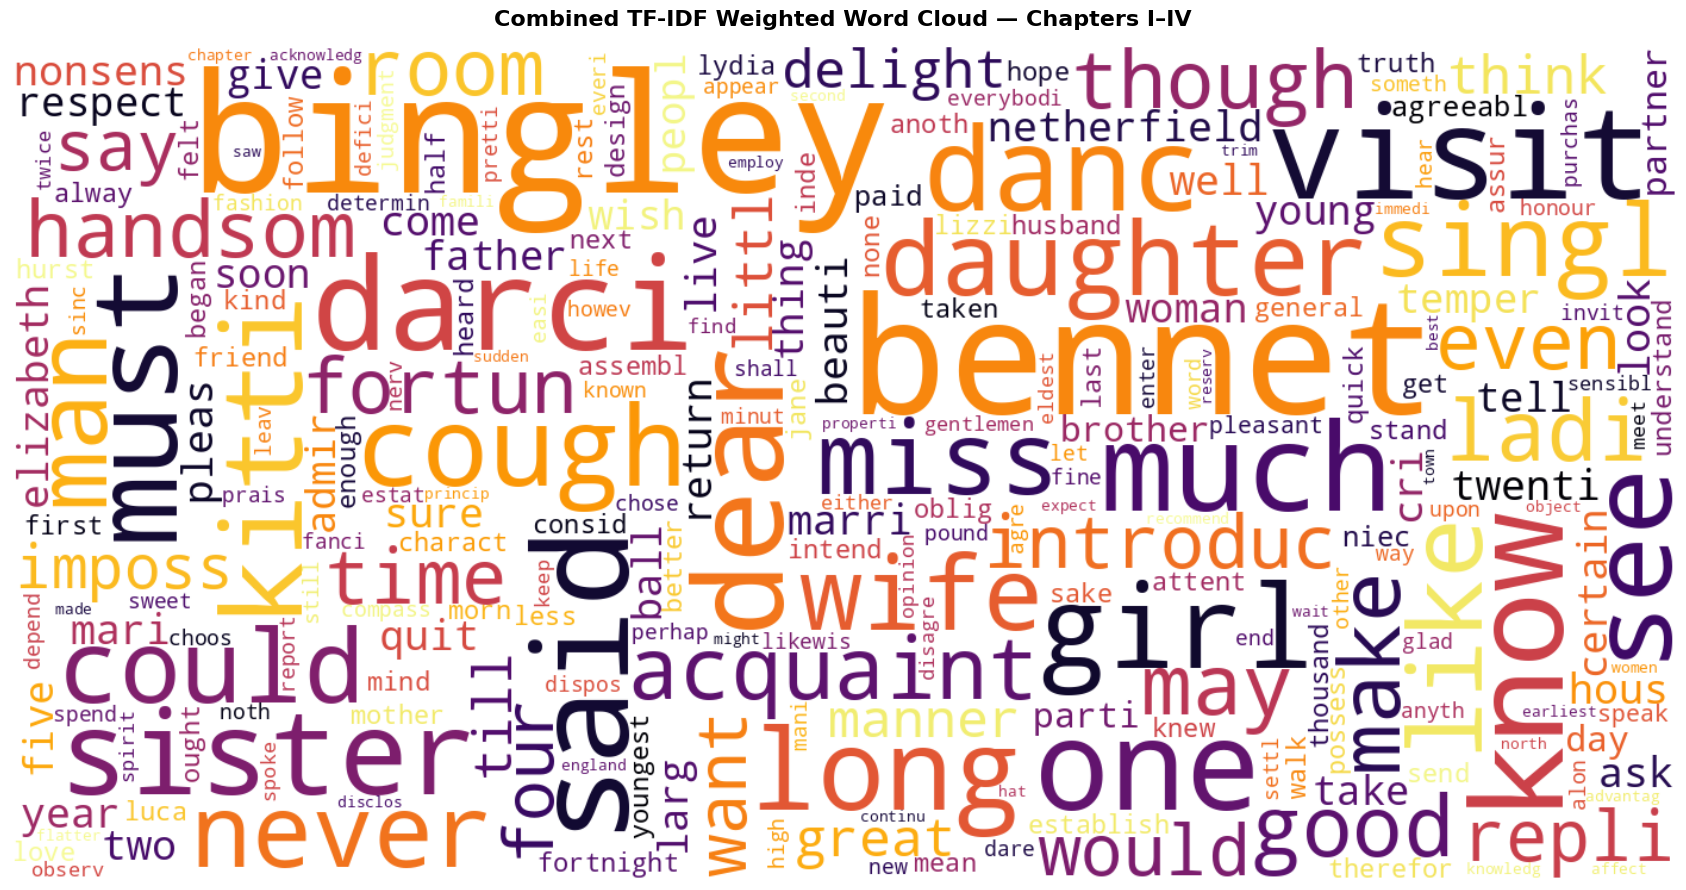

In [27]:
combined_tfidf = {}
for doc_scores in manual_tfidf:
    for term, score in doc_scores.items():
        combined_tfidf[term] = combined_tfidf.get(term, 0.0) + score

logger.info("Combined TF-IDF vocabulary size: %d unique terms", len(combined_tfidf))

top_combined = sorted(combined_tfidf.items(), key=lambda x: x[1], reverse=True)[:15]
logger.info("Top 15 terms by combined TF-IDF score:")
for term, score in top_combined:
    print(f"    {term:<20s} {score:.6f}")

wordcloud_combined = WordCloud(
    width=1400,
    height=700,
    max_words=250,
    background_color="white",
    colormap="inferno",
    collocations=False,
    min_font_size=6,
    max_font_size=140,
    random_state=42,
    prefer_horizontal=0.65
).generate_from_frequencies(combined_tfidf)

plt.figure(figsize=(18, 9))
plt.imshow(wordcloud_combined, interpolation="bilinear")
plt.axis("off")
plt.title("Combined TF-IDF Weighted Word Cloud — Chapters I–IV",
          fontsize=16, fontweight="bold", pad=15)
plt.tight_layout()
plt.show()

# Save for submission
wordcloud_combined.to_file("tfidf_combined_ch1_to_ch4.png")